In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle
df = pd.read_pickle('df_4_1.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39413 entries, 0 to 37232
Data columns (total 73 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   index                              39411 non-null  float64
 1   restaurant_name                    39411 non-null  object 
 2   region                             39411 non-null  object 
 3   city                               39411 non-null  object 
 4   latitude                           39411 non-null  float64
 5   longitude                          39411 non-null  float64
 6   claimed                            39411 non-null  float64
 7   top_tags                           39411 non-null  object 
 8   vegetarian_friendly                39411 non-null  Int64  
 9   vegan_options                      39411 non-null  Int64  
 10  gluten_free                        39411 non-null  Int64  
 11  open_days_per_week                 39411 non-null  float64


### Redundant Features Drop

In [3]:
df.drop(columns=['top_tags'], inplace=True)           # text column, was extracted


### Reviews count indicators - filling missing, dropping to avoid multicollinearity

In [4]:
df['total_reviews_count'].value_counts()

total_reviews_count
0.0      3843
21.0     1215
22.0     1167
23.0     1101
24.0      999
         ... 
175.0      29
173.0      26
159.0      26
165.0      26
178.0      20
Name: count, Length: 159, dtype: int64

In [5]:
df['total_reviews_count'] = df['total_reviews_count'].mask(df['total_reviews_count'] == 0, df['reviews_count_in_default_language'])
df['total_reviews_count'].value_counts()

total_reviews_count
0.0     2384
21.0    1243
22.0    1202
23.0    1136
24.0    1027
        ... 
15.0      19
8.0       15
1.0       13
2.0       13
6.0       12
Name: count, Length: 179, dtype: int64

In [6]:
df.drop(columns=['reviews_count_in_default_language'], inplace=True) # multicollinearity with total_reviews_count

### Vegan indicators - filling missing, dropping duplicates to avoid multicollinearity

In [7]:
df['vegan_options'].value_counts()

vegan_options
0    30932
1     8479
Name: count, dtype: Int64

In [8]:
pd.crosstab(df['vegan_options'], df['vegan_friendly'], margins=True, margins_name='Total')

vegan_friendly,0.0,1.0,Total
vegan_options,,,
0,15565,15365,30930
1,4637,3842,8479
Total,20202,19207,39409


In [9]:
df['vegan_friendly'] = df['vegan_friendly'].mask(df['vegan_friendly'] == 0, df['vegan_options'])

In [10]:
pd.crosstab(df['vegan_options'], df['vegan_friendly'], margins=True, margins_name='Total')

vegan_friendly,0.0,1.0,Total
vegan_options,,,
0,15565,15365,30930
1,0,8479,8479
Total,15565,23844,39409


In [11]:
df.drop(columns=['vegan_options'], inplace=True) # multicollinearity with vegan_friendly, dropped after help with filling

### Different Meals indicators - filling missing, dropping to avoid multicollinearity

In [24]:
# 'Afterhours', 'Breakfast', 'Brunch', 'Dinner', 'Drinks', 'Lunch',
# 'open_morning', 'open_noon', 'open_afternoon', 'open_evening', 'open_late',

In [12]:
# List of pairs
feature_pairs = [
    ('breakfast', 'open_morning'),
    ('lunch', 'open_noon'),
    ('afterhours', 'open_afternoon'),
    ('dinner', 'open_evening'),
    ('drinks', 'open_late')
]

# Keep track of features that remain from the pairs
kept_features = []

for f1, f2 in feature_pairs:
    # Fill NaN values with 0 before converting to int
    df[f1] = df[f1].fillna(0).astype('int')
    df[f2] = df[f2].fillna(0).astype('int')
    
    # Calculate percentage of 1s
    perc_f1 = df[f1].mean()
    perc_f2 = df[f2].mean()
    
    # Determine which feature to keep
    if perc_f2 > perc_f1:
        main, secondary = f2, f1
    else:
        main, secondary = f1, f2
    
    # Fill 0s in main with 1s from secondary
    df[main] = df[main].where(df[main] == 1, df[secondary])
    
    # Drop secondary feature
    if secondary in df.columns:
        df.drop(columns=[secondary], inplace=True)
    
    # Save the kept feature
    kept_features.append(main)

# Print features kept from the original pairs
print("Features kept from the original pairs:")
print(kept_features)



Features kept from the original pairs:
['open_morning', 'lunch', 'open_afternoon', 'dinner', 'open_late']


In [13]:
df.rename(columns={'lunch': 'open_noon'}, inplace=True)
df.rename(columns={'dinner': 'open_evening'}, inplace=True)

In [14]:
df['open_morning']

0        0
1        0
2        1
3        0
4        0
        ..
39410    0
39411    1
39412    0
36799    0
37232    0
Name: open_morning, Length: 39413, dtype: int64

In [16]:
# predictors - comprise the target value formula, hence leaky features

# check if dropped
# df.drop(columns=['excellent'], inplace=True) 
# df.drop(columns=['very_good'], inplace=True) 
# df.drop(columns=['average'], inplace=True) 
# df.drop(columns=['poor'], inplace=True) 
# df.drop(columns=['terrible'], inplace=True) 
# df.drop(columns=['food'], inplace=True) 
# df.drop(columns=['service'], inplace=True) 
# df.drop(columns=['value'], inplace=True) 
# df.drop(columns=['atmosphere'], inplace=True) 

# text column, info was already extracted
df.drop(columns=['keywords'], inplace=True)        
df.drop(columns=['clean_text'], inplace=True) 

### Region - convert to dummies

In [17]:

# Create one-hot encoded columns for 'region'
region_dummies = pd.get_dummies(df['region'], prefix='region')

# Replace any spaces in the column names with underscores
region_dummies.columns = region_dummies.columns.str.replace(' ', '_')

# Add the dummies back to the original dataframe
df = pd.concat([df, region_dummies], axis=1)

# Print the names of the new region columns
print(region_dummies.columns.tolist())


['region_Berlin', 'region_Central_Germany', 'region_Eastern_Germany', 'region_Northern_and_Hanseatic_Coast', 'region_Rhineland‑West', 'region_Southern_Germany']


In [18]:
bool_features = ['region_Berlin', 'region_Central_Germany', 'region_Eastern_Germany', 
                 'region_Northern_and_Hanseatic_Coast', 
                 'region_Rhineland‑West', 'region_Southern_Germany']

# Convert only the specified boolean features to integers (0 or 1)
df[bool_features] = df[bool_features].astype(int)

# Optional: Check the result
print(df[bool_features].dtypes)

region_Berlin                          int64
region_Central_Germany                 int64
region_Eastern_Germany                 int64
region_Northern_and_Hanseatic_Coast    int64
region_Rhineland‑West                  int64
region_Southern_Germany                int64
dtype: object


In [19]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 39413 entries, 0 to 37232
Data columns (total 69 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   index                                39411 non-null  float64
 1   restaurant_name                      39411 non-null  object 
 2   region                               39411 non-null  object 
 3   city                                 39411 non-null  object 
 4   latitude                             39411 non-null  float64
 5   longitude                            39411 non-null  float64
 6   claimed                              39411 non-null  float64
 7   vegetarian_friendly                  39411 non-null  Int64  
 8   gluten_free                          39411 non-null  Int64  
 9   open_days_per_week                   39411 non-null  float64
 10  open_hours_per_week                  39411 non-null  float64
 11  working_shifts_per_week          

In [22]:
df = df[df['clean'].isin([0, 1])]

In [23]:
df['clean'].value_counts()

clean
0.0    39358
1.0       53
Name: count, dtype: int64

### Code to Identify Features Outside the Range [0, 1]

In [24]:
# Select numeric columns from the DataFrame
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns

# Exclude 'latitude' and 'longitude'
numeric_features = numeric_features.drop(['index','avg_rating','latitude', 'longitude'])

# Initialize a list to hold the names of features that don't range from 0 to 1
non_0_1_features = []

# Loop through the numeric features and check their min and max values
for feature in numeric_features:
    min_val = df[feature].min()
    max_val = df[feature].max()
    
    # If the min or max value is not within the range [0, 1], add to the list
    if min_val < 0 or max_val > 1:
        non_0_1_features.append(feature)

# Output the features whose values are outside the [0, 1] range
print("Features with values outside the range [0, 1]:")
print(non_0_1_features)


Features with values outside the range [0, 1]:
['open_days_per_week', 'open_hours_per_week', 'working_shifts_per_week', 'total_reviews_count', 'awards_num', 'awards_level', 'awards_latest_year', 'awards_factor', 'price_range', 'cuisines_num']


### Rescaling to 0-1

In [25]:
# ['open_days_per_week', 'open_hours_per_week', 'working_shifts_per_week', 'total_reviews_count', 
 # 'awards_num', 'awards_level', 'awards_latest_year', 'awards_factor', 'price_range', 'cuisines_num']


from sklearn.preprocessing import MinMaxScaler

# Identify non-0-1 features by checking if the minimum or maximum value of the feature is not in [0, 1]
non_0_1_features = [col for col in numeric_features if df[col].min() != 0 or df[col].max() != 1]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Rescale the non-0-1 features
df[non_0_1_features] = scaler.fit_transform(df[non_0_1_features])

# Check the transformed values
print(df[non_0_1_features].head())

   open_days_per_week  open_hours_per_week  working_shifts_per_week  \
0            1.000000             0.808824                 0.586012   
1            0.714286             0.798469                 0.578510   
2            1.000000             0.808824                 0.586012   
3            0.714286             0.808824                 0.586012   
4            0.714286             0.700853                 0.680360   

   total_reviews_count  awards_num  awards_level  awards_latest_year  \
0             0.117978         0.0           0.0                 0.0   
1             0.146067         0.0           0.0                 0.0   
2             0.213483         0.0           0.0                 0.0   
3             0.325843         0.0           0.0                 0.0   
4             0.168539         0.0           0.0                 0.0   

   awards_factor  price_range  cuisines_num  
0            0.0     0.012208         0.125  
1            0.0     0.024854         0.250  
2 

In [28]:
# Check where NaN values are present
nan_locations = df.isna()

# Print the columns with NaNs
print("Columns with NaNs:")
print(nan_locations.any())

# Print the rows and columns where NaNs are located
print("\nNaN Locations (True indicates NaN):")
print(nan_locations)

# Optionally: Print the specific rows and columns that contain NaNs
print("\nSpecific rows and columns with NaNs:")
print(df[nan_locations.any(axis=1)])  # Prints rows where any NaN is present

Columns with NaNs:
index                                   True
restaurant_name                         True
region                                  True
city                                    True
latitude                                True
                                       ...  
region_Central_Germany                 False
region_Eastern_Germany                 False
region_Northern_and_Hanseatic_Coast    False
region_Rhineland‑West                  False
region_Southern_Germany                False
Length: 69, dtype: bool

NaN Locations (True indicates NaN):
       index  restaurant_name  region   city  latitude  longitude  claimed  \
0      False            False   False  False     False      False    False   
1      False            False   False  False     False      False    False   
2      False            False   False  False     False      False    False   
3      False            False   False  False     False      False    False   
4      False            False   Fal

In [29]:
# Remove rows with any NaN values
df_cleaned = df.dropna()

# Print the cleaned DataFrame
print(df_cleaned)

          index                     restaurant_name            region  \
0      185081.0                         Schreyerhof  Southern Germany   
1      185084.0          Romantik Hotel Alte Vogtei    Rhineland‑West   
2      185085.0  Stefans Restaurant im Limburgerhof    Rhineland‑West   
3      185091.0                             Medison    Rhineland‑West   
4      185094.0                    Ristorante Capri    Rhineland‑West   
...         ...                                 ...               ...   
39406  300381.0                   Restaurant Pfauen  Southern Germany   
39407  300387.0    Ristorante Pizzeria Bei Domenico  Southern Germany   
39408  300390.0                           Joe Peñas  Southern Germany   
39409  300392.0                        Burgerstuble  Southern Germany   
39410  300398.0                  Restaurant Dimitra  Southern Germany   

               city   latitude  longitude  claimed  vegetarian_friendly  \
0        Hessigheim  48.996754   9.200803      0

In [30]:
df = df_cleaned

### Pickle

In [31]:
import pickle
df.to_pickle('df_5_2.pkl')

In [32]:
import pickle
df = pd.read_pickle('df_5_2.pkl')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39409 entries, 0 to 39410
Data columns (total 69 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   index                                39409 non-null  float64
 1   restaurant_name                      39409 non-null  object 
 2   region                               39409 non-null  object 
 3   city                                 39409 non-null  object 
 4   latitude                             39409 non-null  float64
 5   longitude                            39409 non-null  float64
 6   claimed                              39409 non-null  float64
 7   vegetarian_friendly                  39409 non-null  Int64  
 8   gluten_free                          39409 non-null  Int64  
 9   open_days_per_week                   39409 non-null  float64
 10  open_hours_per_week                  39409 non-null  float64
 11  working_shifts_per_week          

In [35]:
df.describe()

,index,latitude,longitude,claimed,vegetarian_friendly,gluten_free,open_days_per_week,open_hours_per_week,working_shifts_per_week,avg_rating,...,indian_food,delivery,clean,asian_food,region_Berlin,region_Central_Germany,region_Eastern_Germany,region_Northern_and_Hanseatic_Coast,region_Rhineland‑West,region_Southern_Germany
count,39411.000000,39411.000000,39411.000000,39411.000000,39411.0,39411.0,39411.000000,39411.000000,39411.000000,39411.000000,...,39411.000000,39411.000000,39411.000000,39411.000000,39413.000000,39413.000000,39413.000000,39413.000000,39413.000000,39413.000000
mean,241160.799066,50.655576,9.784422,0.426561,0.892111,0.10355,0.912981,0.808824,0.586012,4.036170,...,0.023090,0.002157,0.001345,0.090279,0.082485,0.109532,0.044478,0.183721,0.234364,0.345368
std,31635.681010,1.956064,2.176286,0.494389,0.310244,0.304679,0.164393,0.057405,0.189049,0.494263,...,0.150191,0.046391,0.036647,0.286585,0.275106,0.312310,0.206157,0.387261,0.423606,0.475494
min,185081.000000,47.352380,5.888930,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,215085.500000,49.001355,8.112956,0.000000,1.0,0.0,0.857143,0.778462,0.586012,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,239023.000000,50.686695,9.441617,0.000000,1.0,0.0,1.000000,0.808824,0.600451,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,266334.000000,52.377904,11.556254,1.000000,1.0,0.0,1.000000,0.832083,0.680360,4.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,300412.000000,55.036404,14.993756,1.000000,1.0,1.0,1.000000,1.000000,1.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
# List of columns to exclude from the null checks
exclude_columns = ['index', 'restaurant_name', 'city', 'region', 'latitude', 'longitude', 'avg_rating', 'target_value']

# Step 1: Exclude specific columns from the DataFrame
df_to_check = df.drop(columns=exclude_columns)

# Step 2: Check for NaN, <NA>, and None values across the remaining columns
nan_locations = df_to_check.isna()

# Print columns with NaNs or <NA> or None values
print("Columns with NaNs, <NA>, or None:")
print(nan_locations.any())  # True for columns with NaNs or <NA>

# Step 3: Check for empty strings or invalid entries (if any)
empty_string_check = df_to_check.applymap(lambda x: x == '')

print("\nColumns with empty strings:")
print(empty_string_check.any())  # True for columns with empty strings

# Step 4: Check for None or other invalid types in the DataFrame
none_check = df_to_check.applymap(lambda x: x is None)

print("\nColumns with None values:")
print(none_check.any())  # True for columns with None

# Step 5: Check for rows with any of the above (NaN, <NA>, None, empty strings) in the remaining columns
invalid_rows = df[nan_locations | empty_string_check | none_check]

# Display rows with missing or invalid data
print("\nRows with missing or invalid values:")
print(invalid_rows)

# Optionally, drop invalid rows or columns based on the results
# Drop rows with any NaN, <NA>, empty string, or None values (only in columns checked)
cleaned_df = df.dropna(subset=df_to_check.columns)  # Drop rows with NaN in the columns being checked
print("\nCleaned DataFrame (Rows with NaN, <NA>, None removed from the checked columns):")
print(cleaned_df)

Columns with NaNs, <NA>, or None:
claimed                                False
vegetarian_friendly                    False
gluten_free                            False
open_days_per_week                     False
open_hours_per_week                    False
                                       ...  
region_Central_Germany                 False
region_Eastern_Germany                 False
region_Northern_and_Hanseatic_Coast    False
region_Rhineland‑West                  False
region_Southern_Germany                False
Length: 61, dtype: bool

Columns with empty strings:
claimed                                False
vegetarian_friendly                    False
gluten_free                            False
open_days_per_week                     False
open_hours_per_week                    False
                                       ...  
region_Central_Germany                 False
region_Eastern_Germany                 False
region_Northern_and_Hanseatic_Coast    False
region_Rhinel

In [35]:
df.shape


(39409, 69)

### Feature Importance

In [36]:
df['avg_rating'].value_counts().sort_index()

avg_rating
1.5       14
2.0       75
2.5      415
3.0     1949
3.5     7279
4.0    15392
4.5    12928
5.0     1357
Name: count, dtype: int64

In [37]:
# Create binary target based on avg_rating
df['target_value'] = (df['avg_rating'] >= 4.5).astype(int)

# Check distribution
print(df['target_value'].value_counts(normalize=True))

target_value
0    0.637519
1    0.362481
Name: proportion, dtype: float64


In [38]:
y = df['target_value']
X = df.drop(columns=['index', 'restaurant_name', 'city', 'region', 'latitude', 'longitude', 'avg_rating', 'target_value'])

In [39]:
# Count the occurrences and calculate the percentage
counts = df['target_value'].value_counts()
percentages = df['target_value'].value_counts(normalize=True) * 100

# Round the percentages to 1 decimal place
percentages = percentages.round(1)

# Convert percentages to strings with the '%' symbol
percentages = percentages.astype(str) + '%'

# Combine counts and percentages into a single DataFrame for better readability
result = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages
})

result

,Count,Percentage
target_value,,
0,25124,63.8%
1,14285,36.2%


In [40]:
# 1. Import Required Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import sklearn.metrics as skmet

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay



In [41]:
# 2. Define Helper Functions

# Classification metrics function
def classificationMetrics(y_true, y_pred):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred)
    }
    return metrics



In [42]:
# 4. Initialize Models

# Models to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier()
}



### Split by keeping the same y frequency

In [43]:

# First, split the data into training and temp (70-30 split) while keeping the class distribution the same
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=47)  # maintaning same class distribution 

# Now split temp into validation (50% of temp) and test (50% of temp) — 15% each of the total data
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=47)  #  maintaning same class distribution 


In [44]:
y_train.value_counts()

target_value
0    17543
1    10043
Name: count, dtype: int64

In [45]:
y_temp.value_counts()

target_value
0    7581
1    4242
Name: count, dtype: int64

In [46]:
y_valid.value_counts()

target_value
0    3782
1    2129
Name: count, dtype: int64

In [47]:
y_test.value_counts()

target_value
0    3799
1    2113
Name: count, dtype: int64

### Feature Selection

In [49]:
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFE
import numpy as np

# 6. Feature Selection with Lasso, Ridge, Gradient Boosting, and Random Forest

# Lasso (Linear Model)
lasso = Lasso(alpha=5).fit(X_train, y_train)
lasso_selected = (np.abs(lasso.coef_) > 0).astype(int)

# Ridge (Linear Model)
ridge = Ridge(alpha=5).fit(X_train, y_train)
ridge_selected = (np.abs(ridge.coef_) > 0).astype(int)

# Gradient Boosting (Classifier)
gb = GradientBoostingClassifier().fit(X_train, y_train)
gb_selected = (gb.feature_importances_ > 0).astype(int)

# Random Forest (Classifier)
rf = RandomForestClassifier().fit(X_train, y_train)
rf_selected = (rf.feature_importances_ > 0).astype(int)

# SelectKBest (Chi-squared test) - Select top 15 features
selector = SelectKBest(chi2, k=15)  # Select top 15 features
X_new_kbest = selector.fit_transform(X_train, y_train)
kbest_selected = (selector.get_support()).astype(int)  # Binary selection array

# RFE (Recursive Feature Elimination) with Logistic Regression - Select top 15 features
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=15)  # Corrected: keyword argument for number of features
X_new_rfe = rfe.fit_transform(X_train, y_train)
rfe_selected = (rfe.support_).astype(int)  # Binary selection array


In [50]:
# 7. Store Feature Selection Results

# Create a DataFrame to store the feature selection results
selection_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Lasso': lasso_selected, 
    'GradientBoost': gb_selected,
    'RandomForest': rf_selected,
    'Ridge': ridge_selected,
    'SelectKBest_Chi-squared': kbest_selected,    
    'LogisticRegression': rfe_selected    
})

# Sum the number of selections for each feature
selection_df['Sum'] = selection_df[[
    'Lasso', 'GradientBoost', 'RandomForest', 'Ridge', 'SelectKBest_Chi-squared', 'LogisticRegression'
    ]].sum(axis=1)

# Output the feature selection results
print("Feature Selection Results:\n")
print(selection_df)


Feature Selection Results:

                                Feature  Lasso  GradientBoost  RandomForest  \
0                               claimed      0              1             1   
1                   vegetarian_friendly      0              1             1   
2                           gluten_free      0              1             1   
3                    open_days_per_week      0              1             1   
4                   open_hours_per_week      0              1             1   
..                                  ...    ...            ...           ...   
56               region_Central_Germany      0              1             1   
57               region_Eastern_Germany      0              0             1   
58  region_Northern_and_Hanseatic_Coast      0              1             1   
59                region_Rhineland‑West      0              0             1   
60              region_Southern_Germany      0              1             1   

    Ridge  SelectKBest_

In [51]:
selection_df['Sum'].value_counts().sort_index()

Sum
2     9
3    31
4    13
5     8
Name: count, dtype: int64

In [52]:
# 8. Select Features Based on Multiple Model Selections

# Selecting variables with a sum of selections >= 4
final_var = selection_df[selection_df['Sum'] >= 4]['Feature'].tolist()
print("\nFinal Selected Features (selected by at least 4 models):")
for feature in final_var:
    print(feature)



Final Selected Features (selected by at least 4 models):
claimed
gluten_free
open_hours_per_week
total_reviews_count
open_mon
open_sun
michelin
travellers_choice
certificate_of_excellence
awards_num
awards_any
awards_level
awards_latest_year
awards_factor
special_diets_num
default_language_english
default_language_all
seating
gourmet
reservations
latin_food


In [53]:
import pandas as pd
from scipy.stats import spearmanr


# Filter `X_train` 
X_train_selected = X_train[final_var]

# Calculate Spearman correlation between each feature in X_train_selected and y_train
spearman_corrs = {}
for feature in final_var:
    corr, _ = spearmanr(X_train_selected[feature], y_train)  # Spearman correlation
    spearman_corrs[feature] = corr

# Convert the results into a DataFrame for better readability
spearman_corr_df = pd.DataFrame(list(spearman_corrs.items()), columns=['Feature', 'Spearman Correlation'])

# Sort by the absolute value of Spearman Correlation in descending order
spearman_corr_df['Absolute Correlation'] = spearman_corr_df['Spearman Correlation'].abs()
spearman_corr_df = spearman_corr_df.sort_values(by='Absolute Correlation', ascending=False)

# Display the Spearman correlation values (top features first)
print(spearman_corr_df)

# Select top N features based on absolute correlation (e.g., top 10)
top_n_features = spearman_corr_df.head(15)  # Adjust this number based on your preference
top_n_features_list = top_n_features['Feature'].tolist()

# Now, use the selected top N features for further modeling
X_train_selected_top_n = X_train_selected[top_n_features_list]


                      Feature  Spearman Correlation  Absolute Correlation
2         open_hours_per_week             -0.249982              0.249982
7           travellers_choice              0.220754              0.220754
13              awards_factor              0.214990              0.214990
12         awards_latest_year              0.214629              0.214629
11               awards_level              0.210632              0.210632
9                  awards_num              0.206073              0.206073
10                 awards_any              0.182170              0.182170
4                    open_mon             -0.181178              0.181178
14          special_diets_num             -0.169670              0.169670
1                 gluten_free              0.149506              0.149506
8   certificate_of_excellence              0.141403              0.141403
0                     claimed              0.141334              0.141334
5                    open_sun         

In [54]:
# 9. Create DataFrame with Selected Features

# Create the df_model with only the selected features
df_model = df[final_var]
df_model['target_value'] = df['target_value'].copy()

# Output the result to verify
print(f"\nSelected DataFrame Info:\n")
df_model.info()




Selected DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
Index: 39409 entries, 0 to 39410
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   claimed                    39409 non-null  float64
 1   gluten_free                39409 non-null  Int64  
 2   open_hours_per_week        39409 non-null  float64
 3   total_reviews_count        39409 non-null  float64
 4   open_mon                   39409 non-null  float64
 5   open_sun                   39409 non-null  float64
 6   michelin                   39409 non-null  float64
 7   travellers_choice          39409 non-null  float64
 8   certificate_of_excellence  39409 non-null  float64
 9   awards_num                 39409 non-null  float64
 10  awards_any                 39409 non-null  float64
 11  awards_level               39409 non-null  float64
 12  awards_latest_year         39409 non-null  float64
 13  awards_factor           

In [55]:
# 11.  Model Comparison without Imbalance Techniques

# Initialize an empty list to collect results
model_results = []

# Iterate over each model in the models dictionary
for model_name, model in models.items():
    print(f"\nTraining and evaluating {model_name}\n")
    
    # Fit the model on the original, unbalanced data
    model.fit(X_train[final_var], y_train)
    
    # Predict on the validation set
    y_pred = model.predict(X_valid[final_var])
    
    # Get confusion matrix
    cmat = confusion_matrix(y_valid, y_pred)
    
    # Print the confusion matrix
    print(f"Confusion Matrix for {model_name}:")
    print(cmat)
    
    # Collect the classification metrics
    metrics = classificationMetrics(y_valid, y_pred)
    
    # Store the results
    model_results.append({
        "Model": model_name,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "Recall": metrics["Recall"],
        "F1-Score": metrics["F1-Score"],
        "Confusion Matrix": cmat
    })

# Convert results to a DataFrame for easy comparison
model_results_df = pd.DataFrame(model_results)

# Print out the comparison table
print("\nModel Comparison (without imbalance correction):")
print(model_results_df)



Training and evaluating Logistic Regression

Confusion Matrix for Logistic Regression:
[[3323  459]
 [1309  820]]

Training and evaluating Decision Tree

Confusion Matrix for Decision Tree:
[[2944  838]
 [1229  900]]

Training and evaluating Random Forest

Confusion Matrix for Random Forest:
[[3019  763]
 [1164  965]]

Training and evaluating SVM

Confusion Matrix for SVM:
[[3391  391]
 [1366  763]]

Training and evaluating KNN

Confusion Matrix for KNN:
[[2940  842]
 [1113 1016]]

Training and evaluating XGBoost

Confusion Matrix for XGBoost:
[[3248  534]
 [1188  941]]

Model Comparison (without imbalance correction):
                 Model  Accuracy  Precision    Recall  F1-Score  \
0  Logistic Regression  0.700897   0.641126  0.385157  0.481221   
1        Decision Tree  0.650313   0.517837  0.422734  0.465477   
2        Random Forest  0.673998   0.558449  0.453264  0.500389   
3                  SVM  0.702758   0.661179  0.358384  0.464819   
4                  KNN  0.669261   0.

#### XGBoost is highest in F1-Score (balance between precision and recall) (0.522).

In [56]:
# 12.  hyperparameter tuning using GridSearchCV or RandomizedSearchCV

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Use the top selected features
X_train_final = X_train_selected_top_n
X_valid_final = X_valid[top_n_features_list]

# Initialize XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=47
)

# Define a smaller hyperparameter space for faster tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# Use StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=47)  # fewer splits = faster

# F1-Score as the metric
f1_scorer = make_scorer(f1_score)

# RandomizedSearchCV: n_iter controls how many random combinations to try
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # try 50 random combinations
    scoring=f1_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=47
)

# Fit with early stopping using the validation set
random_search.fit(
    X_train_final, y_train, 
    eval_set=[(X_valid_final, y_valid)], 
    early_stopping_rounds=10,
    verbose=False
)

# Best hyperparameters and score
print("Best Hyperparameters:", random_search.best_params_)
print("Best F1-Score:", random_search.best_score_)

# Evaluate on validation set
best_xgb = random_search.best_estimator_
y_valid_pred = best_xgb.predict(X_valid_final)

from sklearn.metrics import classification_report, confusion_matrix
print("\nValidation Set Evaluation:")
print(confusion_matrix(y_valid, y_valid_pred))
print(classification_report(y_valid, y_valid_pred))




Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best F1-Score: 0.4852641476243648

Validation Set Evaluation:
[[3342  440]
 [1314  815]]
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      3782
           1       0.65      0.38      0.48      2129

    accuracy                           0.70      5911
   macro avg       0.68      0.63      0.64      5911
weighted avg       0.69      0.70      0.68      5911



#### - Key Observations:
#### - The best F1-Score achieved during cross-validation was approximately 0.485.
#### - The model showed good precision (0.72) for class 0 but struggled with class 1, 
####     as evidenced by a lower recall (0.38) and F1-score (0.48) for class 1.
#### - The overall accuracy of the model on the validation set was 70%.

In [58]:
# Since the main issue is the low recall for the minority class, we can tune XGBoost with scale_pos_weight to balance the classes
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# Use the top selected features
X_train_final = X_train_selected_top_n
X_valid_final = X_valid[top_n_features_list]

# Calculate scale_pos_weight to handle class imbalance
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos

# Initialize XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=47,
    scale_pos_weight=scale_pos_weight
)

# Smaller hyperparameter space for faster tuning
param_dist = {
    'n_estimators': [100, 200],         # fewer options
    'max_depth': [3, 5],                # shallower trees
    'learning_rate': [0.05, 0.1],       # smaller rates
    'subsample': [0.8, 1.0],            # rows per tree
    'colsample_bytree': [0.8, 1.0],     # features per tree
    'gamma': [0, 0.1],                  # min loss reduction
    'reg_alpha': [0, 0.01],             # L1 regularization
    'reg_lambda': [1, 1.5]              # L2 regularization
}

# StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=47)

# F1-Score as metric
f1_scorer = make_scorer(f1_score)

# RandomizedSearchCV with fewer iterations
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,       # fewer combinations for speed
    scoring=f1_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=47
)

# Fit with early stopping using validation set
random_search.fit(
    X_train_final, y_train, 
    eval_set=[(X_valid_final, y_valid)], 
    early_stopping_rounds=10,
    verbose=False
)

# Best hyperparameters and score
print("Best Hyperparameters:", random_search.best_params_)
print("Best F1-Score:", random_search.best_score_)

# Evaluate on validation set
best_xgb = random_search.best_estimator_
y_valid_pred = best_xgb.predict(X_valid_final)

from sklearn.metrics import classification_report, confusion_matrix
print("\nValidation Set Evaluation:")
print(confusion_matrix(y_valid, y_valid_pred))
print(classification_report(y_valid, y_valid_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best F1-Score: 0.5699130090305061

Validation Set Evaluation:
[[2738 1044]
 [ 866 1263]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74      3782
           1       0.55      0.59      0.57      2129

    accuracy                           0.68      5911
   macro avg       0.65      0.66      0.66      5911
weighted avg       0.68      0.68      0.68      5911



In [ ]:
#### The F1-score of the minority class (class 1) improved from 0.47 → 0.56, which is meaningful improvement.

In [59]:
# Adjust Class Weights
# Set scale_pos_weight = ratio of negative to positive samples
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=47,
    scale_pos_weight=scale_pos_weight,
    **random_search.best_params_  # use your tuned hyperparameters
)

xgb_model.fit(
    X_train_final, y_train,
    eval_set=[(X_valid_final, y_valid)],
    early_stopping_rounds=10,
    verbose=False
)

y_valid_pred = xgb_model.predict(X_valid_final)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_valid, y_valid_pred))
print(classification_report(y_valid, y_valid_pred))



[[2738 1044]
 [ 866 1263]]
              precision    recall  f1-score   support

           0       0.76      0.72      0.74      3782
           1       0.55      0.59      0.57      2129

    accuracy                           0.68      5911
   macro avg       0.65      0.66      0.66      5911
weighted avg       0.68      0.68      0.68      5911



#### Class 1 (minority) F1-score: 0.55, 
#### Class 0 (majority) F1-score: 0.76
#### Overall accuracy: 0.68

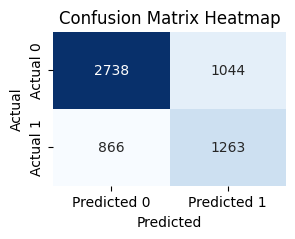

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)

# Plot heatmap
plt.figure(figsize=(3,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix Heatmap')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### Test set

In [63]:
# Prepare the test set with the selected features
X_test_final = X_test[top_n_features_list]

# Get predicted probabilities for the positive class
y_test_proba = xgb_model.predict_proba(X_test_final)[:, 1]

# Apply the optimal threshold
optimal_threshold = 0.4
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix

cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):")
print(cm_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Confusion Matrix (Test Set):
[[2058 1741]
 [ 494 1619]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.54      0.65      3799
           1       0.48      0.77      0.59      2113

    accuracy                           0.62      5912
   macro avg       0.64      0.65      0.62      5912
weighted avg       0.69      0.62      0.63      5912



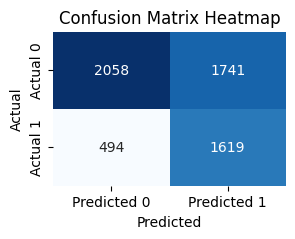

In [62]:

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot heatmap
plt.figure(figsize=(3,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix Heatmap')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### 62% of predictions are correct

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (15).

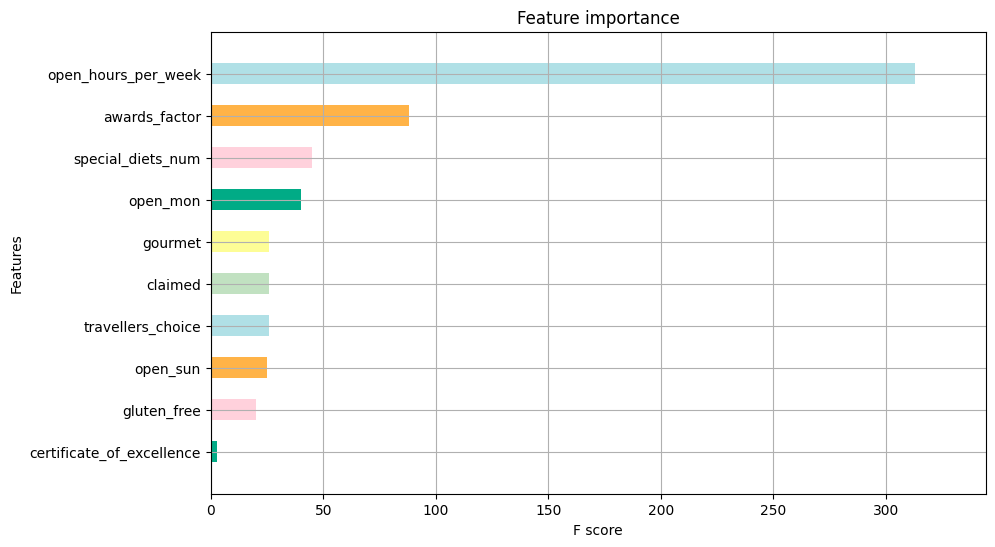

In [71]:
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Custom colors for the bars
custom_colors = [
    "#01ab86",  # brand green
    "#FFD1DC",  # pastel pink
    "#FFB347",  # pastel orange
    "#B0E0E6",  # powder blue
    "#C1E1C1",  # light mint
    "#FDFD96"   # pale yellow
]

# Plot feature importances using the XGBoost's plot_importance function
fig, ax = plt.subplots(figsize=(10, 6))  # Make the figure larger

# Get feature names from your training data (X_train_final)
feature_names = X_train_final.columns  # Assuming your data is a pandas DataFrame

# Plot importance with feature names on y-axis
xgb.plot_importance(
    best_xgb,
    importance_type='weight',  # Can use 'weight', 'gain', or 'cover'
    max_num_features=20,       # Limit to top 20 features
    height=0.5,                # Adjust the bar height (make bars wider)
    ax=ax,
    color=custom_colors,       # Apply custom colors
    show_values=False          # Don't show numerical values on the bars
)

# Adjust y-axis to display feature names correctly
ax.set_yticklabels(feature_names[:20])  # Limit to top 20 features for display

# Remove grid lines
ax.grid(False)  # Disable grid lines

# Remove decimals from the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))

# Optionally, change the axis labels, title, etc.
ax.set_title("Feature Importance", fontsize=16)
ax.set_xlabel("Importance", fontsize=14)
ax.set_ylabel("Features", fontsize=14)

# Show the plot
plt.show()
